In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


# Load and Visualize

In [3]:
class VehicleDataset(Dataset):
    
    def __init__(self, path):
        data = np.load(path)
        self.images = data["images"]
        self.labels = data["labels"]
        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)
        self.__combinelabels__()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        # image_disp = image
        # label = torch.tensor(label, dtype=torch.long)
        # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        # image = (image - mean) / std
        
        return image, label
        
    def __combinelabels__(self):
        for idx, label in enumerate(self.labels):
            if label == 1:
                self.labels[idx] = 1
            if label >= 2 and label <= 7:
                self.labels[idx] = 2
            if label >= 8 and label <= 11:
                self.labels[idx] = 3
            if label >= 12 and label <= 25:
                self.labels[idx] = 4
            if label >= 26 and label <= 38:
               self.labels[idx] = 5
            if label >= 39 and label <= 44:
                self.labels[idx] = 6
            if label >= 45 and label <= 50:
                self.labels[idx] = 7
            if label >= 51 and label <= 53:
                self.labels[idx] = 8
            if label >= 54 and label <= 75:
                self.labels[idx] = 9
            if label >= 76 and label <= 81:
                self.labels[idx] = 10
            if label == 82:
                self.labels[idx] = 11
            if label >= 83 and label <= 97:
                self.labels[idx] = 12
            if label == 98:
                self.labels[idx] = 13
            if label >= 99 and label <= 100:
                self.labels[idx] = 14
            if label >= 101 and label <= 104:
                self.labels[idx] = 15
            if label == 105:
                self.labels[idx] = 16
            if label >= 106 and label <= 117:
                self.labels[idx] = 17
            if label >= 118 and label <= 122:
                self.labels[idx] = 18
            if label == 123:
                self.labels[idx] = 19
            if label >= 124 and label <= 125:
                self.labels[idx] = 20
            if label >= 126 and label <= 129:
                self.labels[idx] = 21
            if label >= 130 and label <= 140:
                self.labels[idx] = 22
            if label >= 141 and label <= 142:
                self.labels[idx] = 23
            if label == 143:
                self.labels[idx] = 24
            if label == 144:
                self.labels[idx] = 25
            if label >= 145 and label <= 149:
                self.labels[idx] = 26
            if label >= 150 and label <= 153:
                self.labels[idx] = 27
            if label >= 154 and label <= 155:
                self.labels[idx] = 28
            if label == 156:
                self.labels[idx] = 29
            if label == 157:
                self.labels[idx] = 30
            if label == 158:
                self.labels[idx] = 31
            if label == 159:
                self.labels[idx] = 32
            if label == 160:
                self.labels[idx] = 33
            if label >= 161 and label <= 166:
                self.labels[idx] = 34
            if label == 167:
                self.labels[idx] = 35
            if label >= 168 and label <= 171:
                self.labels[idx] = 36
            if label == 172:
                self.labels[idx] = 37
            if label == 173:
                self.labels[idx] = 38
            if label == 174:
                self.labels[idx] = 39
            if label >= 175 and label <= 177:
                self.labels[idx] = 40
            if label == 178:
                self.labels[idx] = 41
            if label >= 179 and label <= 180:
                self.labels[idx] = 42
            if label >= 181 and label <= 184:
                self.labels[idx] = 43
            if label == 185:
                self.labels[idx] = 44
            if label >= 186 and label <= 189:
                self.labels[idx] = 45
            if label >= 190 and label <= 192:
                self.labels[idx] = 46
            if label >= 193 and label <= 195:
                self.labels[idx] = 47
            if label == 196:
                self.labels[idx] = 48

In [4]:
dataset = VehicleDataset('../dataset/stanford_cars_dataset.npz')

batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(len(dataset) - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

labels = dataset.labels[:,0] - 1
train_labels = labels[train_dataset.indices]  # get labels for train split

classes, counts = np.unique(train_labels, return_counts=True)
class_weights_np = 1.0 / counts
class_weights_np = class_weights_np / class_weights_np.sum() * len(classes)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

print(f"Class weights: {class_weights}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images shape: (8144, 112, 112, 3)
Labels shape: (8144, 1)
Class weights: tensor([1.6689, 0.3026, 0.4619, 0.1253, 0.1369, 0.3080, 0.3275, 0.6387, 0.0808,
        0.2827, 1.6689, 0.1181, 1.5678, 1.1497, 0.4661, 1.7246, 0.1340, 0.3214,
        1.7246, 0.8482, 0.4661, 0.1680, 1.0779, 1.9162, 1.3983, 0.3214, 0.4538,
        0.9581, 1.7246, 2.1557, 2.7230, 2.3517, 1.4782, 0.2923, 1.5217, 0.4619,
        1.7246, 1.7246, 2.2495, 0.6549, 1.9162, 0.8769, 0.4790, 1.5217, 0.4241,
        0.5504, 0.5685, 1.7840], device='cuda:0')


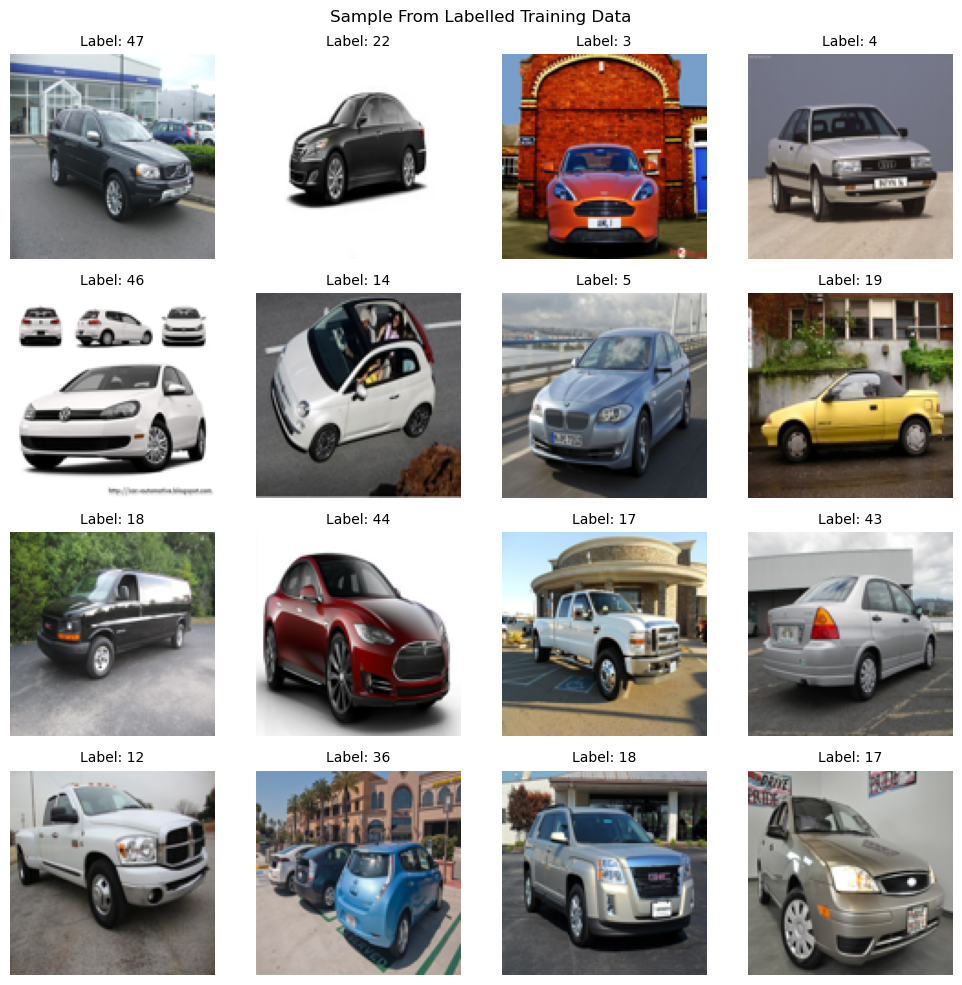

In [5]:
for images, labels in train_loader:
    break 

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("Sample From Labelled Training Data")
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

# LeNet-5
LeNet-5 implementation for 
- 64x64 input (vehicle image dataset)
- Binary Classification (vehicle or no vehicle)
- Modern ReLU Activation

In [6]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)

        self.fc1 = nn.Linear(120*21*21, 84)
        self.fc2 = nn.Linear(84, 48)

        self.avgpool = nn.AvgPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = self.avgpool(self.relu(self.conv1(x)))
        x = self.avgpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Training

In [13]:
def train_model(model):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_acc = 0.0
    patience_counter = 0
    max_patience = 4

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels[:, 0].to(device) - 1

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels[:, 0].to(device) - 1
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Validation Acc: {val_acc:.4f}")

        # # Early stopping
        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     patience_counter = 0
        #     torch.save(model.state_dict(), "best_model.pth")
        # else:
        #     patience_counter += 1
        #     if patience_counter >= max_patience:
        #         print("Early stopping.")
        #         break

        scheduler.step()

    print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")

In [14]:
lenet5 = LeNet5().to(device)
train_model(lenet5)

100%|██████████| 179/179 [00:11<00:00, 15.70it/s]


Epoch 1/50 - Loss: 3.7727 - Accuracy: 0.0577
Validation Acc: 0.1020


100%|██████████| 179/179 [00:11<00:00, 15.54it/s]


Epoch 2/50 - Loss: 3.6753 - Accuracy: 0.0796
Validation Acc: 0.1020


100%|██████████| 179/179 [00:11<00:00, 15.97it/s]


Epoch 3/50 - Loss: 3.6056 - Accuracy: 0.0865
Validation Acc: 0.1020


100%|██████████| 179/179 [00:11<00:00, 15.31it/s]


Epoch 4/50 - Loss: 3.5699 - Accuracy: 0.0854
Validation Acc: 0.1020


100%|██████████| 179/179 [00:11<00:00, 15.30it/s]


Epoch 5/50 - Loss: 3.5324 - Accuracy: 0.0911
Validation Acc: 0.1020


100%|██████████| 179/179 [00:12<00:00, 14.79it/s]


Epoch 6/50 - Loss: 3.5133 - Accuracy: 0.0896
Validation Acc: 0.1038


100%|██████████| 179/179 [00:11<00:00, 15.69it/s]


Epoch 7/50 - Loss: 3.4907 - Accuracy: 0.0940
Validation Acc: 0.1014


100%|██████████| 179/179 [00:11<00:00, 15.32it/s]


Epoch 8/50 - Loss: 3.4882 - Accuracy: 0.0995
Validation Acc: 0.1020


100%|██████████| 179/179 [00:11<00:00, 15.83it/s]


Epoch 9/50 - Loss: 3.4757 - Accuracy: 0.1000
Validation Acc: 0.1026


100%|██████████| 179/179 [00:11<00:00, 15.43it/s]


Epoch 10/50 - Loss: 3.4642 - Accuracy: 0.1000
Validation Acc: 0.1020


100%|██████████| 179/179 [00:11<00:00, 15.54it/s]


Epoch 11/50 - Loss: 3.4572 - Accuracy: 0.1011
Validation Acc: 0.1057


100%|██████████| 179/179 [00:11<00:00, 15.55it/s]


Epoch 12/50 - Loss: 3.4333 - Accuracy: 0.1044
Validation Acc: 0.1057


100%|██████████| 179/179 [00:11<00:00, 15.05it/s]


Epoch 13/50 - Loss: 3.4404 - Accuracy: 0.1014
Validation Acc: 0.1063


100%|██████████| 179/179 [00:11<00:00, 15.43it/s]


Epoch 14/50 - Loss: 3.4329 - Accuracy: 0.1026
Validation Acc: 0.1038


100%|██████████| 179/179 [00:11<00:00, 15.96it/s]


Epoch 15/50 - Loss: 3.4180 - Accuracy: 0.1049
Validation Acc: 0.1050


100%|██████████| 179/179 [00:11<00:00, 15.44it/s]


Epoch 16/50 - Loss: 3.4254 - Accuracy: 0.1019
Validation Acc: 0.1044


100%|██████████| 179/179 [00:11<00:00, 15.42it/s]


Epoch 17/50 - Loss: 3.4183 - Accuracy: 0.1047
Validation Acc: 0.1050


100%|██████████| 179/179 [00:11<00:00, 15.98it/s]


Epoch 18/50 - Loss: 3.4190 - Accuracy: 0.1077
Validation Acc: 0.1069


100%|██████████| 179/179 [00:11<00:00, 15.85it/s]


Epoch 19/50 - Loss: 3.4076 - Accuracy: 0.1111
Validation Acc: 0.1063


100%|██████████| 179/179 [00:12<00:00, 14.80it/s]


Epoch 20/50 - Loss: 3.4118 - Accuracy: 0.1060
Validation Acc: 0.1044


100%|██████████| 179/179 [00:11<00:00, 15.30it/s]


Epoch 21/50 - Loss: 3.3926 - Accuracy: 0.1125
Validation Acc: 0.1069


100%|██████████| 179/179 [00:11<00:00, 15.70it/s]


Epoch 22/50 - Loss: 3.3941 - Accuracy: 0.1098
Validation Acc: 0.1057


100%|██████████| 179/179 [00:13<00:00, 13.56it/s]


Epoch 23/50 - Loss: 3.4084 - Accuracy: 0.1063
Validation Acc: 0.1063


100%|██████████| 179/179 [00:11<00:00, 15.04it/s]

Epoch 24/50 - Loss: 3.3943 - Accuracy: 0.1121


Validation Acc: 0.1044


100%|██████████| 179/179 [00:12<00:00, 14.78it/s]


Epoch 25/50 - Loss: 3.4070 - Accuracy: 0.1107
Validation Acc: 0.1069


100%|██████████| 179/179 [00:11<00:00, 15.43it/s]


Epoch 26/50 - Loss: 3.4079 - Accuracy: 0.1032
Validation Acc: 0.1069


100%|██████████| 179/179 [00:13<00:00, 13.37it/s]


Epoch 27/50 - Loss: 3.3942 - Accuracy: 0.1081
Validation Acc: 0.1063


100%|██████████| 179/179 [00:13<00:00, 13.47it/s]


Epoch 28/50 - Loss: 3.3971 - Accuracy: 0.1170
Validation Acc: 0.1075


100%|██████████| 179/179 [00:22<00:00,  7.99it/s]


Epoch 29/50 - Loss: 3.3965 - Accuracy: 0.1077
Validation Acc: 0.1057


100%|██████████| 179/179 [00:31<00:00,  5.67it/s]


Epoch 30/50 - Loss: 3.4117 - Accuracy: 0.1114
Validation Acc: 0.1063


100%|██████████| 179/179 [00:27<00:00,  6.55it/s]


Epoch 31/50 - Loss: 3.3969 - Accuracy: 0.1096
Validation Acc: 0.1063


100%|██████████| 179/179 [00:32<00:00,  5.54it/s]


Epoch 32/50 - Loss: 3.3970 - Accuracy: 0.1133
Validation Acc: 0.1057


100%|██████████| 179/179 [00:29<00:00,  6.15it/s]


Epoch 33/50 - Loss: 3.3936 - Accuracy: 0.1075
Validation Acc: 0.1075


100%|██████████| 179/179 [00:28<00:00,  6.28it/s]


Epoch 34/50 - Loss: 3.3940 - Accuracy: 0.1047
Validation Acc: 0.1069


100%|██████████| 179/179 [00:31<00:00,  5.76it/s]


Epoch 35/50 - Loss: 3.3949 - Accuracy: 0.1160
Validation Acc: 0.1069


100%|██████████| 179/179 [00:36<00:00,  4.88it/s]


Epoch 36/50 - Loss: 3.3961 - Accuracy: 0.1091
Validation Acc: 0.1063


100%|██████████| 179/179 [00:29<00:00,  6.03it/s]


Epoch 37/50 - Loss: 3.3977 - Accuracy: 0.1053
Validation Acc: 0.1063


100%|██████████| 179/179 [00:27<00:00,  6.42it/s]


Epoch 38/50 - Loss: 3.3994 - Accuracy: 0.1107
Validation Acc: 0.1057


100%|██████████| 179/179 [00:30<00:00,  5.78it/s]


Epoch 39/50 - Loss: 3.3927 - Accuracy: 0.1174
Validation Acc: 0.1057


100%|██████████| 179/179 [00:27<00:00,  6.42it/s]


Epoch 40/50 - Loss: 3.3926 - Accuracy: 0.1093
Validation Acc: 0.1063


100%|██████████| 179/179 [00:34<00:00,  5.14it/s]

Epoch 41/50 - Loss: 3.3972 - Accuracy: 0.1039


Validation Acc: 0.1063


100%|██████████| 179/179 [00:33<00:00,  5.31it/s]


Epoch 42/50 - Loss: 3.3960 - Accuracy: 0.1100
Validation Acc: 0.1057


100%|██████████| 179/179 [00:38<00:00,  4.70it/s]


Epoch 43/50 - Loss: 3.4089 - Accuracy: 0.1128
Validation Acc: 0.1057


100%|██████████| 179/179 [00:32<00:00,  5.56it/s]


Epoch 44/50 - Loss: 3.3870 - Accuracy: 0.1089
Validation Acc: 0.1063


100%|██████████| 179/179 [00:33<00:00,  5.27it/s]


Epoch 45/50 - Loss: 3.3956 - Accuracy: 0.1077
Validation Acc: 0.1057


100%|██████████| 179/179 [00:44<00:00,  3.99it/s]


Epoch 46/50 - Loss: 3.3965 - Accuracy: 0.1119
Validation Acc: 0.1057


100%|██████████| 179/179 [00:46<00:00,  3.83it/s]


Epoch 47/50 - Loss: 3.3990 - Accuracy: 0.1068
Validation Acc: 0.1063


100%|██████████| 179/179 [00:35<00:00,  5.10it/s]


Epoch 48/50 - Loss: 3.3980 - Accuracy: 0.1054
Validation Acc: 0.1063


100%|██████████| 179/179 [00:30<00:00,  5.81it/s]


Epoch 49/50 - Loss: 3.3900 - Accuracy: 0.1111
Validation Acc: 0.1063


100%|██████████| 179/179 [00:30<00:00,  5.77it/s]


Epoch 50/50 - Loss: 3.3850 - Accuracy: 0.1077
Validation Acc: 0.1063

Best Validation Accuracy: 0.0000


# Testing

In [11]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    rmse = 0.0
    mae = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1 
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            # print(labels.shape)
            # rmse += np.sqrt(np.mean((preds - labels) ** 2)) * images.size(0)
            # mae = torch.abs(preds - labels).sum()

    accuracy = correct / total

    print(f'Test Accuracy: {accuracy:.4f}')
    
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    mae = torch.mean(torch.abs(all_preds.float() - all_labels.float())).item()
    rmse = torch.sqrt(torch.mean((all_preds.float() - all_labels.float()) ** 2)).item()

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    
    return accuracy, all_preds, all_labels

In [12]:
test_model(lenet5, test_loader, device)

Test Accuracy: 0.1287
MAE: 11.4179
RMSE: 16.1445


(0.12867647058823528,
 tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11,  8,  8,  8,  3,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  8,  8,  8, 11,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 16,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  8,  8,  8,  8,  8,
      

In [15]:
torch.save(lenet5.state_dict(), 'lenet5.pth')